# EDA of Game Dataset

## About

The purpose of this project is to create a ML model to predict the success of a game.

The minimum required to complete this project would be to convert all non-numerical features into a numerical format that the algorithm can understand, and to decide which feature(s) to use to measure a games success.


## Dataset

When performing EDA we can take a top-down approach by examining attributes of the entire dataset.

This can help us be more mindful of issues that exist on the individual feature level.

In [109]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from IPython.display import Image
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image


sns.set_style('darkgrid')
games_df = pd.read_csv('../data/raw/games.csv', index_col=0)

In [2]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30250 entries, 0 to 30249
Data columns (total 26 columns):
id                  30250 non-null int64
Name                30156 non-null object
RawgID              30156 non-null float64
SteamURL            30195 non-null object
Metacritic          3356 non-null float64
Genres              27282 non-null object
Indie               30045 non-null float64
Presence            30156 non-null float64
Platform            30123 non-null object
Graphics            25930 non-null object
Storage             27491 non-null object
Memory              28316 non-null object
RatingsBreakdown    15044 non-null object
ReleaseDate         27024 non-null object
Soundtrack          30045 non-null float64
Franchise           5087 non-null object
OriginalCost        29504 non-null object
DiscountedCost      727 non-null object
Players             12334 non-null object
Controller          29976 non-null float64
Languages           30027 non-null object
ESRB    

### Dealing with Duplicates

In [17]:
games_df.duplicated().sum()

0

It looks like there are no completely duplicated observtions, though when we begin to analyze the features that should be unique (id like features) then we will have a better sense of whether or not we have any duplicates.

### Check for NaN values:

In [3]:
games_df.isna().sum()

id                      0
Name                   94
RawgID                 94
SteamURL               55
Metacritic          26894
Genres               2968
Indie                 205
Presence               94
Platform              127
Graphics             4320
Storage              2759
Memory               1934
RatingsBreakdown    15206
ReleaseDate          3226
Soundtrack            205
Franchise           25163
OriginalCost          746
DiscountedCost      29523
Players             17916
Controller            274
Languages             223
ESRB                25503
Achievements           94
Publisher           30250
Description           219
Tags                  205
dtype: int64

There are a lot of missing values. We are going to have to deal with each of these features individually and come up with a solution for each.

### id

Database primary key. Indicates the order the games were entered.

Unique identifier's are usually not helpful for modeling any relationship, but this id is different.

It represents the order the games were scraped, which was originally sorted by popularity, so it can actually be used as our predicted variable (y).


In [19]:
print(f"Unique: {games_df['id'].nunique()}/{games_df.shape[0]}")
print(f"Nan: {games_df['id'].isna().sum()}")

Unique: 30250/30250
Nan: 0


## Name
Original title of the game. 

In [10]:
print(f"Unique: {games_df['Name'].nunique()}/{games_df.shape[0]}")
print(f"Nan: {games_df['Name'].isna().sum()}")

Unique: 27407/30250
Nan: 94


First let's address the Nan values:

In [129]:
pd.set_option('max_colwidth', 40)

In [132]:
games_df[games_df['Name'].isna()].isna().sum()

id                   0
Name                94
RawgID              94
SteamURL             0
Metacritic          94
Genres               6
Indie                0
Presence            94
Platform            94
Graphics            15
Storage              7
Memory               7
RatingsBreakdown    94
ReleaseDate         94
Soundtrack           0
Franchise           84
OriginalCost         3
DiscountedCost      94
Players             48
Controller           0
Languages            0
ESRB                94
Achievements        94
Publisher           94
Description         94
Tags                 0
dtype: int64

These Nans will have to be dropped, since the 'Name' features is what links the Steam data to the RAWG data.

As we can see above, any of the 94 games that have Nan title also is missing all RAWG data.

In [73]:
games_df[games_df['Name'].duplicated()]['Name'].value_counts()

7 Billion Humans                            221
InMind VR                                    33
Fight Night: Knight Fight                    14
The Oil Blue: Steam Legacy Edition           12
Grand Theft Auto V                           11
                                           ... 
A Detective's Novel                           1
Deep Sky Derelicts                            1
ULTRAWORLD EXODUS                             1
The Incredible Adventures of Van Helsing      1
Shadowgrounds: Survivor                       1
Name: Name, Length: 1790, dtype: int64

We will probably be dropping all 1,790 duplicate games. 

It's worth exploring deeper though in case we can devise a solution.

### Exploring Deeper:
Starting with FIFA 20

In [60]:
games_df[games_df['Name'] == 'FIFA 20']

,id,Name,RawgID,SteamURL,Metacritic,Genres,Indie,Presence,Platform,Graphics,...,OriginalCost,DiscountedCost,Players,Controller,Languages,ESRB,Achievements,Publisher,Description,Tags
23380,23381,FIFA 20,326229.0,https://store.steampowered.com/app/9...,68.0,NaN,1.0,1000735.0,"Nintendo Switch, PlayStation 4, Xbox...",Nvidia GeForce GTX970 / AMD Radeon R...,...,$29.99,NaN,NaN,1.0,"English, Japanese, German, Russian",Everyone,63.0,NaN,"Powered by Frostbite™*, EA SPORTS™ F...","Action, Simulation, Indie, Casual, A..."
24266,24267,FIFA 20,326229.0,https://store.steampowered.com/app/1...,68.0,"Casual, Simulation",0.0,1000735.0,"Nintendo Switch, PlayStation 4, Xbox...",Graphics card with DX10 capabilities,...,$2.99,NaN,NaN,0.0,English,Everyone,63.0,NaN,"Powered by Frostbite™*, EA SPORTS™ F...","Casual, Simulation, Relaxing, Music,..."
30242,30243,FIFA 20,326229.0,https://store.steampowered.com/app/1...,68.0,"Indie, Strategy",1.0,1000736.0,"Nintendo Switch, PlayStation 4, Xbox...",Intel® HD Graphics,...,$4.99,NaN,singleplayer,0.0,English,Everyone,63.0,NaN,"Powered by Frostbite™*, EA SPORTS™ F...","Indie, Strategy, Puzzle, Singleplaye..."


### Investigate the Mislabeled Data:
Time to check the URLS manually and see if they are all incorrect.

To do this we will use Selenium to load the game page and take a screenshot which it will save in memory, then use matplotlib to show the img so we can compare visually whether or not the titles match:

In [90]:
fifa_imgs = []
for url in games_df[games_df['Name'] == 'FIFA 20']['SteamURL'].values:
    driver = webdriver.Safari()
    driver.get(url)
    sleep(1)

    fifa_imgs.append(driver.get_screenshot_as_png())
    driver.quit()


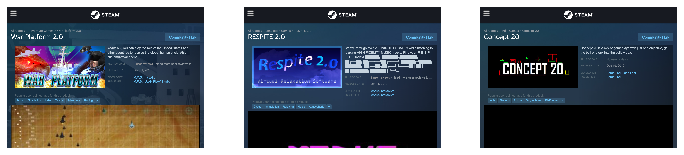

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
for ax, png in zip(ax.flatten(), fifa_imgs):
    img = Image.open(BytesIO(png))
    ax.imshow(img)
    ax.grid(False)
    ax.axis('off')

All of the three games with the Name 'FIFA 20' are incorrect and point to different games.


### Are all the games incorrect?!
At this point it's important to check samples from the data to make sure this is an isolated issue.

We will do the same thing except now we will draw random samples from our dataset:

In [122]:
random_imgs = {
    'titles': [],
    'imgs': []
}
for idx, game in games_df.sample(9).iterrows():
    driver = webdriver.Safari()
    driver.get(game['SteamURL'])
    sleep(1)

    random_imgs['titles'].append(game['Name'])
    random_imgs['imgs'].append(driver.get_screenshot_as_png())
    driver.quit()

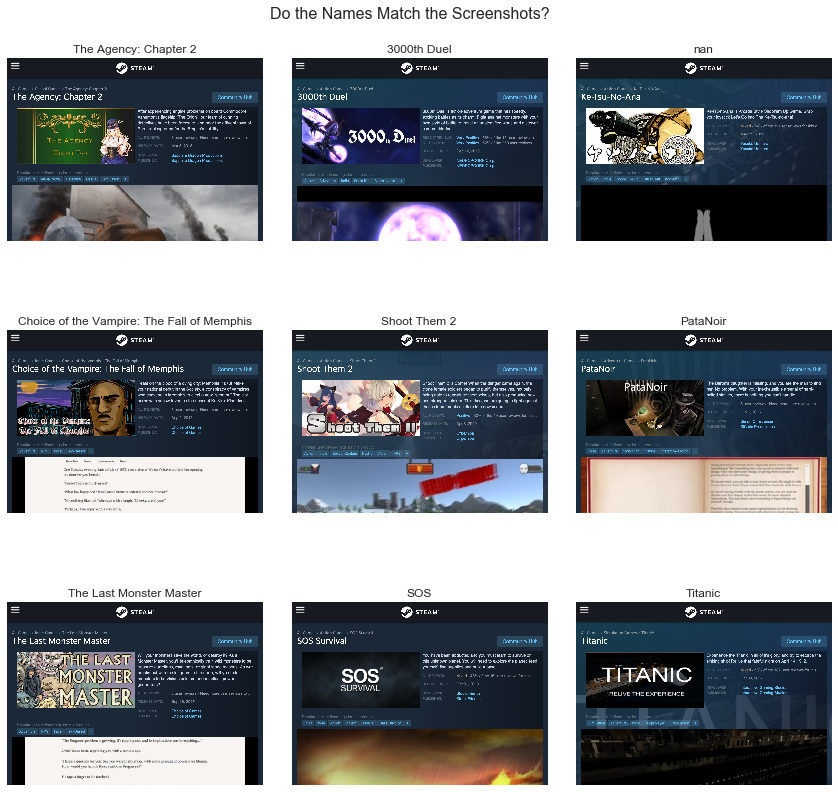

In [141]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for ax, title, img in zip(ax.flatten(), random_imgs['titles'], random_imgs['imgs']):
    img = Image.open(BytesIO(img))
    ax.imshow(img)
    ax.grid(False)
    ax.axis('off')
    ax.set_title(title)
plt.tight_layout()
fig.suptitle('Do the Names Match the Screenshots?', fontsize=16);


Okay, so these all have the correct title.

At this point I think its safe to assume the duplicates are the only games effected. We will keep a watchful eye however in case any other issues come up.

### Why so many copies of 7 Billion Humans

Thats a lot of games with the name '7 Billion Humans'. Let's inspect this further.

In [36]:
games_df[games_df['Name'] == '7 Billion Humans'].head(3)

,id,Name,RawgID,SteamURL,Metacritic,Genres,Indie,Presence,Platform,Graphics,...,OriginalCost,DiscountedCost,Players,Controller,Languages,ESRB,Achievements,Publisher,Description,Tags
798,799,7 Billion Humans,52005.0,/,NaN,RPG,NaN,53317.0,"PC, macOS, iOS, Linux, Nintendo Switch",NaN,...,$49.99,NaN,NaN,NaN,NaN,NaN,19.0,NaN,Automate swarms of office workers to solve puz...,NaN
871,872,7 Billion Humans,52005.0,NaN,NaN,NaN,NaN,53317.0,"PC, macOS, iOS, Linux, Nintendo Switch",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,Automate swarms of office workers to solve puz...,NaN
1035,1036,7 Billion Humans,52005.0,NaN,NaN,NaN,NaN,53317.0,"PC, macOS, iOS, Linux, Nintendo Switch",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,Automate swarms of office workers to solve puz...,NaN


So we can see that for each of these games, the SteamURL is either '/' or nan. 

It must have been an error with the gathering process. Let's make sure by selecting all rows that have either '/' nan:

In [142]:
games_df[games_df['SteamURL'].isin([np.nan, '/'])]['Name'].value_counts()

7 Billion Humans         221
140                        1
24/7 Sorcerer's Arena      1
Name: Name, dtype: int64

We can see there is indeed an error and all of the '7 Billion Humans' show up along with 140 (?) and 24/7 Sorcerer's Arena.

### InMind VR
The next game on the list with far too many duplicates:

In [134]:
games_df[games_df['Name'] == 'InMind VR'].head(3)

,id,Name,RawgID,SteamURL,Metacritic,Genres,Indie,Presence,Platform,Graphics,...,OriginalCost,DiscountedCost,Players,Controller,Languages,ESRB,Achievements,Publisher,Description,Tags
919,920,InMind VR,13575.0,https://store.steampowered.com/app/7...,NaN,NaN,0.0,82271.0,"iOS, Linux, PC, macOS",NVIDIA GTX 970 or GTX 1060 or better...,...,$49.99,NaN,singleplayer,1.0,"English, Japanese",NaN,0.0,NaN,InMind is a short scientific adventu...,"Sexual Content, Nudity, Mature, VR, ..."
1849,1850,InMind VR,13575.0,https://store.steampowered.com/app/1...,NaN,NaN,0.0,82271.0,"iOS, Linux, PC, macOS",NVIDIA GTX 1060,...,Demo Sample,NaN,NaN,1.0,English,NaN,0.0,NaN,InMind is a short scientific adventu...,"Simulation, VR, Experience, Relaxing..."
2036,2037,InMind VR,13575.0,https://store.steampowered.com/app/9...,NaN,NaN,1.0,82271.0,"iOS, Linux, PC, macOS",Nvidia Gtx 960,...,NaN,NaN,singleplayer,1.0,English,NaN,0.0,NaN,InMind is a short scientific adventu...,"Action, Adventure, Utilities, Early ..."


Thankfully these games have valid URL's so we can once again use Selenium to fetch some screenshots of the game landing pages for us to compare:

In [135]:
vr_imgs = []
for idx, game in games_df[games_df['Name'] == 'InMind VR'].sample(9).iterrows():
    driver = webdriver.Safari()
    driver.get(game['SteamURL'])
    sleep(1)
    vr_imgs.append(driver.get_screenshot_as_png())
    driver.quit()

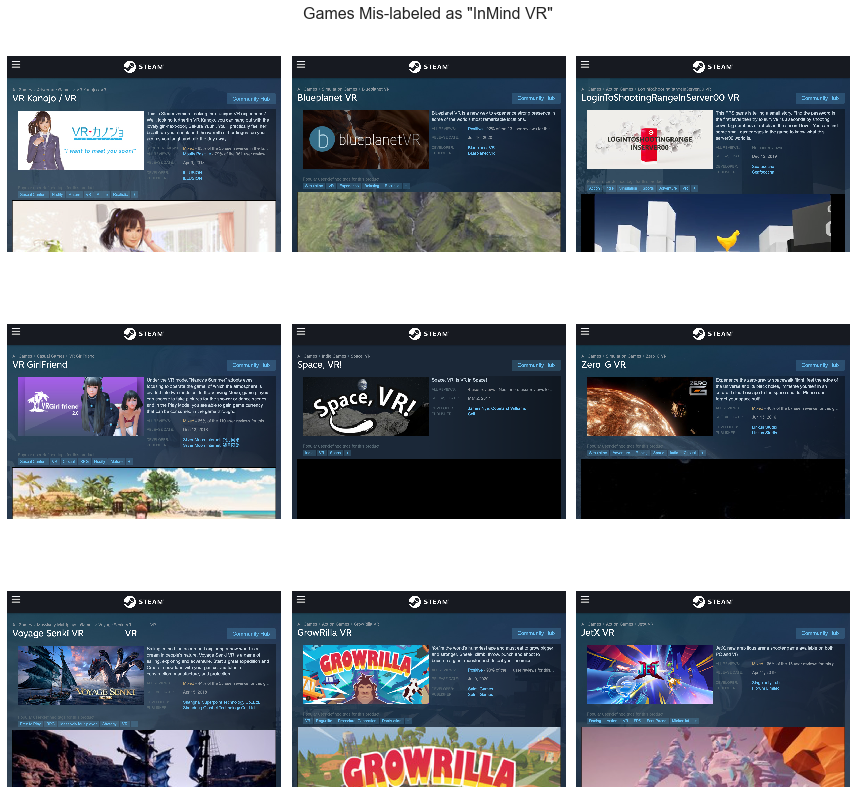

In [139]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(ax.flatten(), vr_imgs):
    img = Image.open(BytesIO(img))
    ax.imshow(img)
    ax.grid(False)
    ax.axis('off')
plt.tight_layout()
fig.suptitle('Games Mis-labeled as "InMind VR"', fontsize=16);

Okay, after visiting the urls it turns out that the games that are tagged as 'VR' are somehow all classified as this 'InMind VR'.

We could fill these in manually since we have the urls, however we are not too concerned with VR for now.

Instead of carrying on this way we will go ahead and drop duplicates, since there are less than 300 and most of those are from the '7 Billion Humans' error.

### Solutions:
- Drop all games with '/' or nan as the SteamURL
- Drop all duplicate games, as they have been wrong so far.
- Drop any games with 'Nan' as the Name

## RawgID
Another feature that should be a unique identifier.

Not super important because we will be dropping it since it is usesless for modeling, but it might be worthwile to checkout and try to gain some insight about the other features.


In [153]:
print(f"Unique: {games_df['RawgID'].nunique()}")
print(f"Nan: {games_df['RawgID'].isna().sum()}")
print(f"Ranges from {games_df['RawgID'].min()} to {games_df['RawgID'].max()}")

Unique: 27407
Nan: 94
Ranges from 2.0 to 463726.0


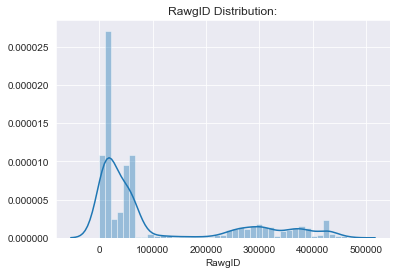

In [156]:
sns.distplot(games_df['RawgID'].dropna())
plt.title('RawgID Distribution:');

Right away we know the 94 Nan values are the same 94 that were missing their Name attribute. We already decided to drop these observations so we won't worry about them.

The fact that there are only 27,407 unique entries though is interesting. Are they the duplicates from the '7 Billion Humans' error we explored earlier?

In [148]:
games_df[games_df['RawgID'].duplicated()]['Name'].value_counts()

7 Billion Humans                            221
InMind VR                                    33
Fight Night: Knight Fight                    14
The Oil Blue: Steam Legacy Edition           12
Grand Theft Auto V                           11
                                           ... 
A Detective's Novel                           1
Deep Sky Derelicts                            1
ULTRAWORLD EXODUS                             1
The Incredible Adventures of Van Helsing      1
Shadowgrounds: Survivor                       1
Name: Name, Length: 1790, dtype: int64

This list looks familiar. These are all the same games that had the wrong URL's assigned to them.

This is actually a good sign, because it means when we fix the issues relating to the 'Name' feature, we will also fix the problems with the 'RawgID' feature.

### Solution:
- Dropping this column since it will be useless for our project

## SteamURL
Very important feature for troubleshooting since we can look up the page if we have any questions about the data, just like we did above. 

Not useful for our project however as its another unique feature.

In [158]:
print(f"Unique: {games_df['SteamURL'].nunique()}")
print(f"Nan: {games_df['SteamURL'].isna().sum()}")

Unique: 29298
Nan: 55


These should be different Nan values than the ones in 'Name' and 'RawgID', since those were both values gathered from the RAWG API.

Let's inspect and see:

In [162]:
games_df[games_df['SteamURL'].isna()]['Name'].value_counts()

7 Billion Humans    54
140                  1
Name: Name, dtype: int64

It looks like all the Nan values are from the '7 Billion Humans' game yet again. Taking care of those duplicates will improve the quality of the dataset by a lot!

### Solutions:
- Drop this feature for the modeling and analysis phase

## Metacritic
The score given to the game from the Metacritic organization

This feature could potentially be valuable, however it is missing a large percentage of values.

In [171]:
print(f"Unique: {games_df['Metacritic'].nunique()}")
print(f"Nan: {games_df['Metacritic'].isna().sum()}")
print(f"Actual Number of Ratings: {games_df['Metacritic'].shape[0] - games_df['Metacritic'].isna().sum()}")

Unique: 71
Nan: 26894
Actual Number of Ratings: 3356


We have Metacritic scores for just over 10% of our dataset. Not great!

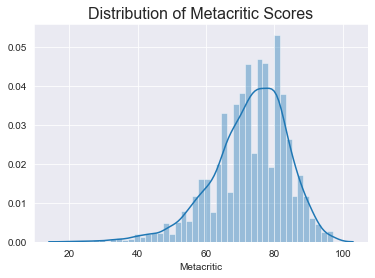

In [167]:
sns.distplot(games_df['Metacritic'].dropna())
plt.title('Distribution of Metacritic Scores', fontsize=16);

The ratings that we have however have a pretty nice looking distribution, even though it's slightly left-skewed!

### Solutions:
- 

### Genres

In [242]:
basic_stats('Genres')

--------------------
Unique: 1007/30250
Missing: 2968
--------------------
Too many unique values to plot!


In [243]:
games_df['Genres'].value_counts()

Action, Indie                                                                      1911
Casual, Indie                                                                      1446
Action, Adventure, Indie                                                           1350
Adventure, Indie                                                                   1302
Action, Casual, Indie                                                               963
                                                                                   ... 
Action, Adventure, Indie, Racing, RPG, Simulation, Early Access                       1
Action, Casual, Indie, Massively Multiplayer, Racing, Simulation, Early Access        1
Action, Adventure, Casual, Free to Play, Massively Multiplayer, RPG, Simulation       1
Casual, Racing, Strategy                                                              1
Action, Adventure, Simulation, Strategy, Early Access                                 1
Name: Genres, Length: 1007, dtyp

### Indie

--------------------
Unique: 2/30250
Missing: 205
--------------------


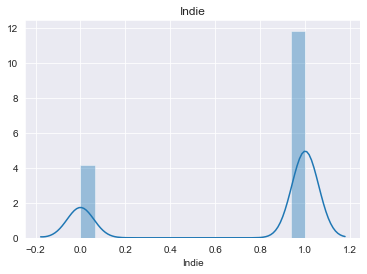

In [215]:
basic_stats('Indie')

### Presence

--------------------
Unique: 7419/30250
Missing: 94
--------------------


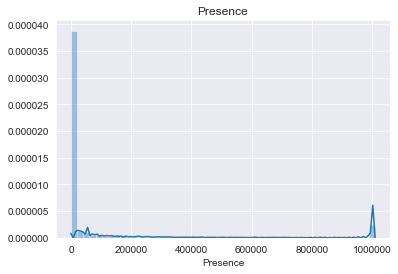

In [216]:
basic_stats('Presence')

### Platform

In [217]:
basic_stats('Platform')

--------------------
Unique: 2041/30250
Missing: 127
--------------------
Too many unique values to plot!


### RatingsBreakdown

In [218]:
basic_stats('RatingsBreakdown')

--------------------
Unique: 4806/30250
Missing: 15206
--------------------
Too many unique values to plot!


### ReleaseDate

In [219]:
basic_stats('ReleaseDate')

--------------------
Unique: 4133/30250
Missing: 3226
--------------------
Too many unique values to plot!


### Soundtrack

--------------------
Unique: 2/30250
Missing: 205
--------------------


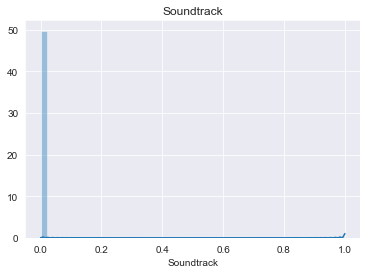

In [220]:
basic_stats('Soundtrack')

### Franchise

In [221]:
basic_stats('Franchise')

--------------------
Unique: 1866/30250
Missing: 25163
--------------------
Too many unique values to plot!


### OriginalCost

In [222]:
basic_stats('OriginalCost')

--------------------
Unique: 396/30250
Missing: 746
--------------------
Too many unique values to plot!


### DiscountedCost

In [223]:
basic_stats('DiscountedCost')

--------------------
Unique: 121/30250
Missing: 29523
--------------------
Too many unique values to plot!


### Players

In [224]:
basic_stats('Players')

--------------------
Unique: 29/30250
Missing: 17916
--------------------


TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Controller

--------------------
Unique: 2/30250
Missing: 274
--------------------


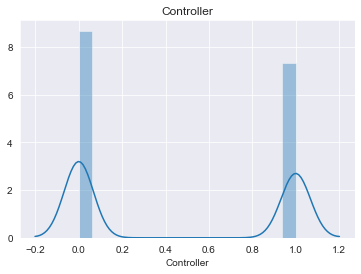

In [225]:
basic_stats('Controller')

### ESRB

In [226]:
basic_stats('ESRB')

--------------------
Unique: 6/30250
Missing: 25503
--------------------


TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Achievements

--------------------
Unique: 448/30250
Missing: 94
--------------------


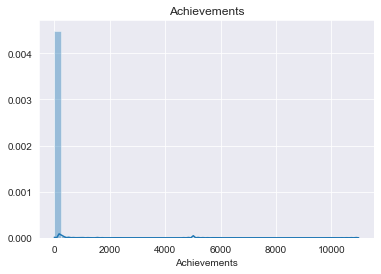

In [227]:
basic_stats('Achievements')

### Publisher

--------------------
Unique: 0/30250
Missing: 30250
--------------------


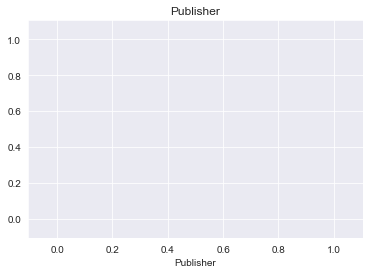

In [228]:
basic_stats('Publisher')

### Languages

In [229]:
basic_stats('Languages')

--------------------
Unique: 3196/30250
Missing: 223
--------------------
Too many unique values to plot!


### Graphics

In [230]:
basic_stats('Graphics')

--------------------
Unique: 10546/30250
Missing: 4320
--------------------
Too many unique values to plot!


### Storage

In [231]:
basic_stats('Storage')

--------------------
Unique: 2067/30250
Missing: 2759
--------------------
Too many unique values to plot!


### Memory

In [232]:
basic_stats('Memory')

--------------------
Unique: 699/30250
Missing: 1934
--------------------
Too many unique values to plot!


### Tags

In [233]:
basic_stats('Tags')

--------------------
Unique: 24866/30250
Missing: 205
--------------------
Too many unique values to plot!


### Description

In [234]:
basic_stats('Description')

--------------------
Unique: 27271/30250
Missing: 219
--------------------
Too many unique values to plot!
